This notebook will describe experiments related to DUD-E

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('text', usetex=True)


In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
#     import pdb
#     pdb.set_trace()
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [4]:
dude_target_names = [x.stem.split("-")[0].split("_")[1] for x in list(data_p.glob("dude_*_random.pkl"))]
dude_target_names

['dyr',
 'inha',
 'aces',
 'cdk2',
 'kith',
 'esr1',
 'gcr',
 'rxra',
 'ampc',
 'hivrt',
 'pgh1',
 'bace1',
 'nram',
 'pygm',
 'mcr',
 'pgh2',
 'parp1',
 'ada',
 'comt',
 'pparg',
 'vgfr2',
 'pnph',
 'prgr',
 'thrb',
 'pur2',
 'hmdh',
 'mk14',
 'hs90a',
 'ace',
 'pde5a',
 'src',
 'hivpr',
 'aldr',
 'try1',
 'andr',
 'fa10',
 'sahh',
 'egfr']

In [5]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# DUD-E results

In [6]:
color_dict = {
    "smiles-pe": "steelblue",
    "ecfp": "lightcoral",
    "rp": "seagreen",
    "rf": "plum",
    "openhd": "green",
    "mlp": "slateblue"
}

marker_dict = {
    "smiles-pe": "+",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
    "openhd": "*",
    "mlp": "+"
}


def aggregate_dude_results(dataset, split):
    
    model_metric_dict = {}
    
    
    enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(16,6))
    enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(16,6))

    
    enrich_1_f.suptitle("Enrichment at 1\% of database")
    enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
#         color, marker = model_tup
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"{dataset}*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            target = path.stem.split("_")[1]
            split = path.stem.split(".")[0].split("_")[-1]
            split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
            split_df = pd.read_csv(split_file)
            
            train_size = split_df[split_df["subset"] == "train"].shape[0] 
            test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time = load_pkl(path, model=model, return_sizes=False)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
#         sns.boxplot(x=sorted_metric_list, ax=ax[0], color=color, hue=color)
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)
#         sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_enrich_1_list, ax=enrich_1_ax, color=color, marker=marker, 
#                                                                         label=f"{model}: {np.mean(sorted_enrich_1_list):0.2f}")
#         sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_enrich_10_list, ax=enrich_10_ax, color=color, marker=marker, 
#                                                                         label=f"{model}: {np.mean(sorted_enrich_10_list):0.2f}")

    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    return f, ax, enrich_1_f, enrich_1_ax, enrich_10_f, enrich_10_ax, model_metric_dict




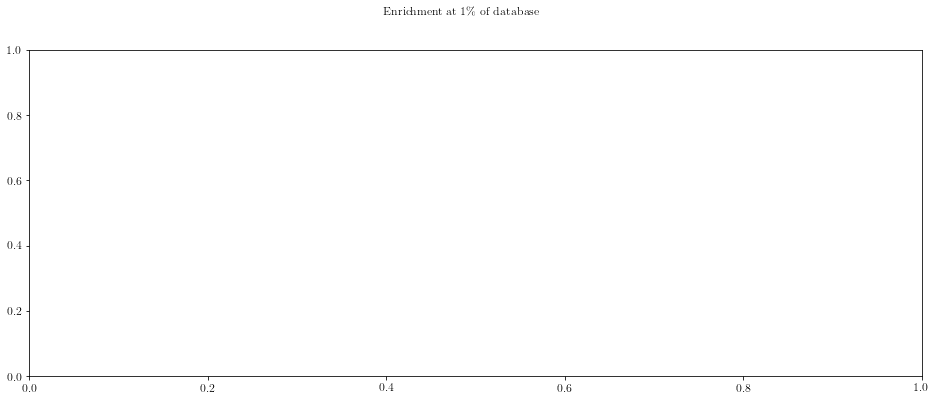

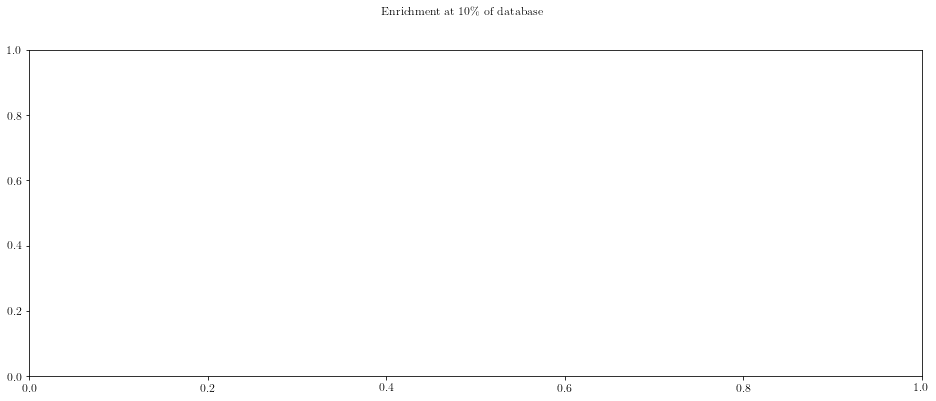

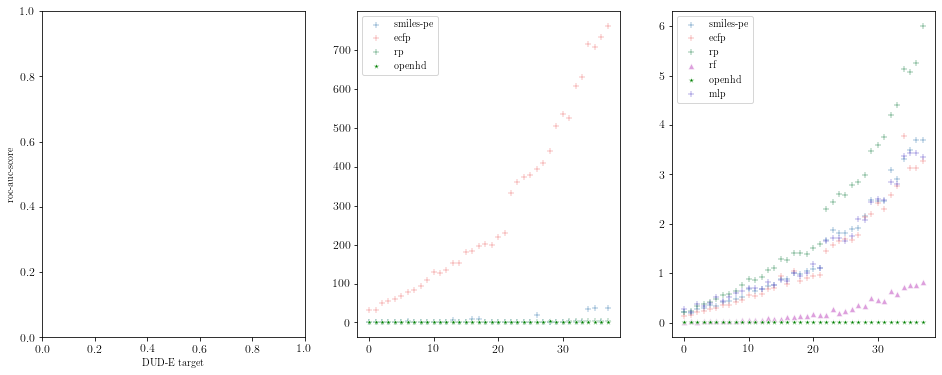

In [7]:
dude_f, dude_ax, dude_enrich_1_f, dude_enrich_1_ax, dude_enrich_10_f, dude_enrich_10_ax, model_metric_dict = aggregate_dude_results(dataset="dude", split="random")
# plt.savefig('dude-results-all.png', dpi=600)


# for model, metric_dist in model_metric_dict.items():

In [8]:
model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

,metric,enrich-1,enrich-10,model
0,0.444444,[52.037037037037045],[9.595482006829524],smiles-pe
1,0.500000,[26.0],[8.666666666666668],smiles-pe
2,0.361111,[50.54671717171717],[8.87625065824118],smiles-pe
3,0.342857,[64.42527472527472],[8.853669467787114],smiles-pe
4,0.750000,[22.333333333333332],[9.925925925925926],smiles-pe
...,...,...,...,...
33,0.933333,[16.68888888888889],[9.881578947368421],mlp
34,1.000000,[45.285714285714285],[9.90625],mlp
35,0.940000,[32.84],[9.951515151515151],mlp
36,1.000000,[47.285714285714285],[9.735294117647058],mlp


In [9]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

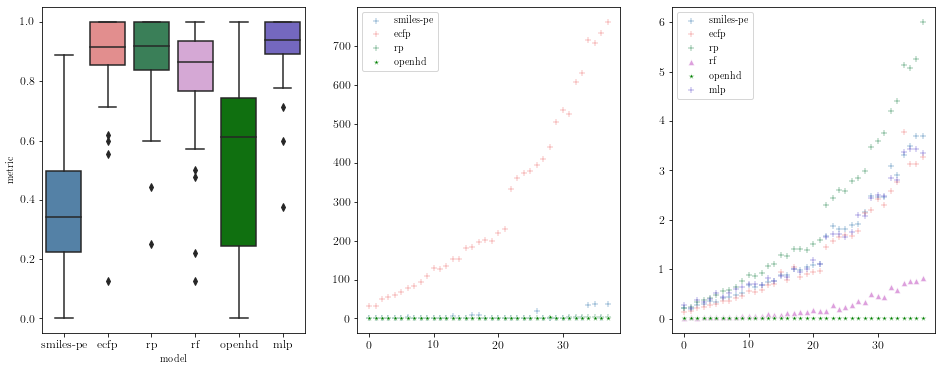

In [10]:
sns.boxplot(data=model_metric_df, x="model", y="metric", ax=dude_ax[0], palette=color_dict)
dude_f

## Vina Docking baseline

In [11]:
vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")


color_dict.update({"Vina": "salmon"})



vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]


df_list = []


root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
for idx, path in  enumerate(vina_path_list):
#     print(idx, path)
    target = path.name.split(".")[0].split("-")[0]
    print(target, idx+1, path)
    
    # for some reason don't have inactive data for abl1
    if target in ["abl1"]:
        continue
    if target in dude_target_names:
    
        active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
        active_df['y_true'] = [1] * len(active_df)
    
        decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
        decoy_df['y_true'] = [0] * len(decoy_df)
    
    
        target_df = pd.concat([active_df, decoy_df])
        
        target_df["target"] = [target] * len(target_df)
    
        target_df["vina"] = target_df[2]
        target_df["gbsa"] = target_df[3]
        
        target_df["cmpd_id"] = target_df[1]
        
        target_df["target_size"] = target_df.shape[0]
        
        
        random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))
        
        
#         import pdb
#         pdb.set_trace()

        # we only use the scores from the test set to attempt an even comparison
    
        merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
        merged_df = merged_df.loc[merged_df['subset'] == "test"]

        print(merged_df.shape)
    
        df_list.append(merged_df)
    else:
        pass

df = pd.concat(df_list)
    

pgh1 1 /p/lustre1/jones289/DUDE-38/pgh1-active-summary.txt
(941, 11)
rxra 2 /p/lustre1/jones289/DUDE-38/rxra-active-summary.txt
(568, 11)
pnph 3 /p/lustre1/jones289/DUDE-38/pnph-active-summary.txt
(655, 11)
ampc 4 /p/lustre1/jones289/DUDE-38/ampc-active-summary.txt
(295, 11)
try1 5 /p/lustre1/jones289/DUDE-38/try1-active-summary.txt
(782, 11)
parp1 6 /p/lustre1/jones289/DUDE-38/parp1-active-summary.txt
(2673, 11)
comt 7 /p/lustre1/jones289/DUDE-38/comt-active-summary.txt
(406, 11)
andr 8 /p/lustre1/jones289/DUDE-38/andr-active-summary.txt
(643, 11)
sahh 9 /p/lustre1/jones289/DUDE-38/sahh-active-summary.txt
(336, 11)
ace 10 /p/lustre1/jones289/DUDE-38/ace-active-summary.txt
(1587, 11)
cdk2 11 /p/lustre1/jones289/DUDE-38/cdk2-active-summary.txt
(2604, 11)
fgfr1 12 /p/lustre1/jones289/DUDE-38/fgfr1-active-summary.txt
hmdh 13 /p/lustre1/jones289/DUDE-38/hmdh-active-summary.txt
(789, 11)
nram 14 /p/lustre1/jones289/DUDE-38/nram-active-summary.txt
(587, 11)
aces 15 /p/lustre1/jones289/DUDE-3

In [12]:
set(df['target'].values.tolist())

{'ace',
 'aces',
 'ada',
 'aldr',
 'ampc',
 'andr',
 'bace1',
 'cdk2',
 'comt',
 'dyr',
 'egfr',
 'esr1',
 'fa10',
 'gcr',
 'hivpr',
 'hivrt',
 'hmdh',
 'hs90a',
 'inha',
 'kith',
 'mcr',
 'mk14',
 'nram',
 'parp1',
 'pde5a',
 'pgh1',
 'pgh2',
 'pnph',
 'pparg',
 'prgr',
 'pur2',
 'pygm',
 'rxra',
 'sahh',
 'src',
 'thrb',
 'try1',
 'vgfr2'}

In [13]:
df

,0,1,2,3,y_true,target,vina,gbsa,cmpd_id,target_size,subset
65,158,CHEMBL178355,-7.3,-23.4889,1,pgh1,-7.3,-23.4889,CHEMBL178355,9475,test
68,161,CHEMBL283267,-7.7,-26.2514,1,pgh1,-7.7,-26.2514,CHEMBL283267,9475,test
69,162,CHEMBL184374,-7.1,-22.7434,1,pgh1,-7.1,-22.7434,CHEMBL184374,9475,test
79,171,CHEMBL433892,-7.3,-29.1098,1,pgh1,-7.3,-29.1098,CHEMBL433892,9475,test
90,180,CHEMBL404928,-6.6,-22.1502,1,pgh1,-6.6,-22.1502,CHEMBL404928,9475,test
...,...,...,...,...,...,...,...,...,...,...,...
8660,994,ZINC35141443,-7.8,-28.5967,0,gcr,-7.8,-28.5967,ZINC35141443,11247,test
8661,9941,ZINC08387402,-7.3,-5.9566,0,gcr,-7.3,-5.9566,ZINC08387402,11247,test
8678,9969,ZINC64795840,-7.4,-20.0953,0,gcr,-7.4,-20.0953,ZINC64795840,11247,test
8698,9992,ZINC02647100,-5.5,-11.0534,0,gcr,-5.5,-11.0534,ZINC02647100,11247,test


In [14]:
target_size_list = []
vina_enrich_1_list = []
vina_enrich_10_list = []

for target, target_df in df.groupby("target"):
    
    ef_1 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.1)

    
    target_size_list.append(target_df.shape[0])
    
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    
sorted_vina_enrich_1_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_1_list), key=lambda pair: pair[0])]
sorted_vina_enrich_10_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_10_list), key=lambda pair: pair[0])]



ace, 1.6811	1.3534	1587
aces, 12.2992	4.7184	2126
ada, 0.0000	0.2302	574
aldr, 3.5769	1.5330	837
ampc, 0.0000	1.2292	295
andr, 18.3714	2.9677	643
bace1, 3.6061	2.6398	1529
cdk2, 1.4183	1.7606	2604
comt, 0.0000	0.9002	406
dyr, 0.0000	1.7635	1459
egfr, 4.3677	2.2381	3219
esr1, 3.6968	2.2181	1597
fa10, 5.4376	2.1879	1687
gcr, 0.0000	2.3696	872
hivpr, 1.3017	3.1342	3087
hivrt, 0.0000	2.6167	157
hmdh, 0.0000	0.9665	789
hs90a, 0.0000	0.0000	466
inha, 0.0000	1.7438	211
kith, 0.0000	0.5402	282
mcr, 9.7333	3.8933	146
mk14, 7.4759	2.5798	3079
nram, 0.0000	0.0000	587
parp1, 10.4211	3.9371	2673
pde5a, 8.6297	2.4922	2223
pgh1, 0.0000	1.1006	941
pgh2, 4.0780	3.1823	1725
pnph, 5.1984	2.2054	655
pparg, 5.8793	4.6167	2265
prgr, 12.3974	4.0899	967
pur2, 6.1795	5.1908	241
pygm, 0.0000	0.9015	357
rxra, 18.9333	9.9649	568
sahh, 0.0000	0.0000	336
src, 3.2879	1.9727	2992
thrb, 4.9508	4.0506	880
try1, 2.7153	1.7873	782
vgfr2, 21.6409	4.8374	1864


I think it would be good to move away from the per-target (sorted by size) scatter plot and instead make a series of box plots...this should make it easier to compare the enrichment factors as you increase the amount of data that you are allowed to screen

In [15]:
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*38, "enrich-1": sorted_vina_enrich_1_list, 
                                            "enrich-10": sorted_vina_enrich_10_list,
                                          "model": ["Vina"]*38})])

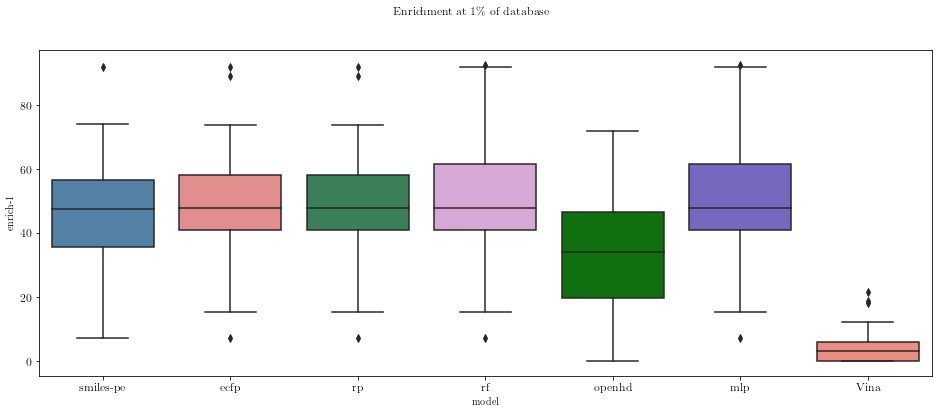

In [16]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=dude_enrich_1_ax, palette=color_dict)
dude_enrich_1_f

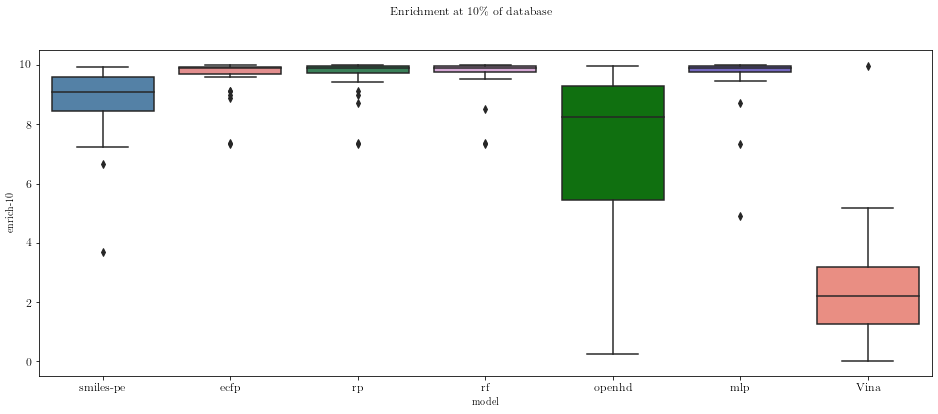

In [17]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=dude_enrich_10_ax, palette=color_dict)
dude_enrich_10_f

In [18]:
model_metric_df

,metric,enrich-1,enrich-10,model
0,0.444444,52.037037,9.595482,smiles-pe
1,0.500000,26.000000,8.666667,smiles-pe
2,0.361111,50.546717,8.876251,smiles-pe
3,0.342857,64.425275,8.853669,smiles-pe
4,0.750000,22.333333,9.925926,smiles-pe
...,...,...,...,...
33,0.000000,10.421053,3.937058,Vina
34,0.000000,3.287912,1.972747,Vina
35,0.000000,7.475893,2.579807,Vina
36,0.000000,1.301708,3.134209,Vina


In [19]:
# HD-CUDA is deprecated version of OpenHD, which is a GPU-accelerated version of HD

#def hd_cuda_main(f, ax):
#     root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/deepchem_feats")
    
#     train_size_list = []
#     encode_time_list = []
#     train_time_list = []
#     test_time_list = []

# #     import pdb
# #     pdb.set_trace()
#     for path in root_dir.glob("*/ecfp/run.out"):
# #         print(path)
# #         '''
#         df = pd.read_csv(path, header=None)
# #         print(df.head(df.shape[0]))
# #         '''
#         num_train_epochs = int(df.loc[4][0])
        
#         encode_time = float(df.loc[21][0].split(' ')[-1]) /1000
#         train_time = float(df.loc[22][0].split(' ')[-1]) / 1000 / num_train_epochs
#         test_time = float(df.loc[23][0].split(' ')[-1]) /1000
#         train_size = int(df.loc[13][0])
        
#         encode_time_list.append(encode_time)
#         train_time_list.append(train_time)
#         test_time_list.append(test_time)
#         train_size_list.append(train_size)
    
#     sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
#     sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
#     sorted_test_time_list = [x for _, x in sorted(zip(train_size_list, test_time_list), key=lambda pair: pair[0])]
#     sorted_train_size_list = sorted(train_size_list)
# #         '''
        
#     sns.scatterplot(x=[x for x in range(len(sorted_train_size_list))], y=sorted_encode_time_list, ax=ax[1], label="HD-CUDA", color="lightcoral")
#     ax[1].set_ylabel("encode-time (s)")
#     sns.scatterplot(x=[x for x in range(len(sorted_train_size_list))], y=sorted_train_time_list, ax=ax[2], label="HD-CUDA", color="lightcoral")
#     ax[2].set_ylabel("train-time-per-epoch (s)")
# #     sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[2], label="HD-CUDA")
# #     ax[2].set_ylabel("test-time (s)")
#     return f, ax

        
# hd_cuda_main(f=dude_f, ax=dude_ax)
# dude_ax[1].set_yscale("log")
# dude_f

